In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pandas as pd
import pdb
import os
import shutil
device= 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:

def tranform_tensor(point, center,scale, resolution, inverse=False):

    _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

    h = 200 * scale
    t = torch.eye(3).repeat(len(scale),1,1)
    t[:,0,0] = resolution / h
    t[:,1,1] = resolution / h
    t[:,0,2] = resolution *(-centers[:,0]/h + 0.5)
    t[:,1,2] = resolution *(-centers[:,1]/h + 0.5)
    if inverse:
        t = torch.inverse(t)

    return torch.matmul(t,_pt)

def crop_and_resize_tensor(imgs, center, scale, resolution=256):
    """"
    function that crops and resizes a batch of images using a center and scale 
    Arguments:
        image {torch.tensor} -- a batch of images. N,C,H,W 
        center {torch.tensor} -- the center of the object, usually the same as of the bounding box
        scale {torch.tensor} -- scale of the face
    Keyword Arguments:
        resolution {float} -- the size of the output cropped image (default: {256.0})
    Returns:
        image {torch.tensor} -- a batch of cropped images. N,C,H,W 
    """
    #todo -- make this work in a batch...
    
    #current size
    N,C,H,W = imgs.shape
    ul_b = tranform_tensor([1,1],center,scale, resolution, inverse = True)
    br_b = tranform_tensor([resolution,resolution],center,scale, resolution, inverse = True)
    out_imgs = torch.zeros((N,C,resolution,resolution))
    for image, ul_t,bl_t, k in zip(imgs,ul_b,br_b, range(N)):
        ul=np.round(ul_t.numpy(),0).astype(np.int)
        br=np.round(bl_t.numpy(),0).astype(np.int)
        newImg = torch.zeros([C,int(br[1]-ul[1]),int(br[0]-ul[0])]).int()
        newX = np.array(
        [max(1, -ul[0] + 1), min(br[0], W) - ul[0]], dtype=np.int32)
        newY = np.array(
        [max(1, -ul[1] + 1), min(br[1], H) - ul[1]], dtype=np.int32)
        oldX = np.array([max(1, ul[0] + 1), min(br[0], W)], dtype=np.int32)
        oldY = np.array([max(1, ul[1] + 1), min(br[1], H)], dtype=np.int32)
        
        #newImg[:,int(newY[0]) - 1:int(newY[1]), int(newX[0]) - 1:int(newX[1])
        #   ] = image[:,int(oldY[0]) - 1:int(oldY[1]), int(oldX[0]) - 1:int(oldX[1])]
        
        newImg[:,int(newY[0]):int(newY[1]), int(newX[0]):int(newX[1])] = image[:,int(oldY[0]):int(oldY[1]), int(oldX[0]):int(oldX[1])]
        out_imgs[k] = nn.functional.interpolate(newImg.unsqueeze_(0).float(), size=(resolution, resolution))
        
        
        
    return out_imgs
    
   # new_image = torch.zeros((N,C,))

def _descale(p, s): return (0.5*(p+1.))*s 

In [4]:
#face detector 
from arch.net_blazeface import BlazeFace
face_detector = BlazeFace()
face_detector.load_state_dict(torch.load('/home/deniz/Code/ClinicalScore/share_mobilenet/pretrained_models/blazeface.pth'))
face_detector.load_anchors_from_npy(np.load('/home/deniz/Code/ClinicalScore/share_mobilenet/pretrained_models/anchors.npy'), device)
#Move model to gpu or cpu 
face_detector.to(device);
#tell Pytorch that you will use the model -- not train the model 
face_detector.eval();

In [5]:
#landmarks finder
from arch.MobileNetV2 import mobilenet_v2
from arch.softargmax import SpatialSoftArgmax2d
class HeadBlock(nn.Module):
    def __init__(self, in_channels, proj_channels, out_channels, **kwargs):
        super(HeadBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 1, bias=False),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_channels, out_channels, 1, bias=False),
            )
        
        self.softargmax = SpatialSoftArgmax2d()
        
    def forward(self, input):
        out = []
        out.append(self.layers(input))
        out.append(self.softargmax(out[-1]))
        return out
    
backbone = mobilenet_v2()
nopoints = 68
head = HeadBlock(152, 152, nopoints)
model_mobilenet = nn.Sequential(backbone, head)
model_mobilenet.load_state_dict(torch.load('/home/deniz/Code/ClinicalScore/share_mobilenet/code/models/models_MobineNet_300W_softmax_pretrainedImagenet/FineTuned_TorontoNeuroFace_Epoch_11.pth'), strict=False)
model_mobilenet.eval();
model_mobilenet.to(device);

In [6]:
avi_path = r'/media/deniz/easystore/facial_tracking_data_2021/mobileNet_lookups.csv'
avi_df = pd.read_csv(avi_path)
avi_df = avi_df.drop("Unnamed: 0", axis=1)
avi_df.head()

,subject,task,date,avi_path
0,AF01,OPEN,20170509,/media/deniz/easystore/facial_tracking_data_20...
1,AF01,OPEN,20170509,/media/deniz/easystore/facial_tracking_data_20...
2,AF01,SPREAD,20170509,/media/deniz/easystore/facial_tracking_data_20...
3,AF01,SPREAD,20170509,/media/deniz/easystore/facial_tracking_data_20...
4,AF01,PUCKER,20170509,/media/deniz/easystore/facial_tracking_data_20...


In [6]:

population = ['ALS', 'PLS', 'Kennedys', 'Post-stroke', 'Healthy_Control']

tasks = ['BBP_NORMAL', 'NSM_OPEN', 'NSM_SPREAD', 'NSM_BIGSMILE' , 'RST_REST', 'NSM_KISS', 'NSM_PUCKER', 'DDK_PA']


base_path = '/media/deniz/easystore/facial_tracking_data_2021'
output_subfolder = 'LANDMARKS/mobileNet'
sufix = '_landmarksPixels2D.csv'

In [7]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


error_avi = []

for index, row in avi_df.iterrows():
     
    
    color_file = row['avi_path']
    
    
    print('Starting: ', color_file)
    print()
    splited_name = color_file.split('/')
    name = splited_name[-1][:-4]
    root_path = '/'.join(splited_name[:-2])
    
    folder  = os.path.join(root_path,output_subfolder)
    csv_name = os.path.join(folder, name + sufix)
    
    if os.path.exists(csv_name):
        continue 
        
    if not os.path.exists(folder):
        os.makedirs(folder)
    vid = torchvision.io.read_video(color_file, pts_unit='sec')
    
    
    try: 
        #create batches
        idx = np.arange(vid[0].shape[0])
        batch_size=200
        q = int(idx.shape[0] / batch_size)
        block_end = q * batch_size
        batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

        F,H,W,C = vid[0].shape
        landmarks = np.zeros((F,68,2))
        #this for facial localization 
        des_dim = 128
        yshift, xshift = 0, (H-W)//2
        xstart = (int(W*(128/H))-des_dim)//2

        ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
        resolution = 256
        vid_crop = torch.zeros((F,C,resolution,resolution))

        with torch.no_grad():
            for batch in batch_idx:

                imgs = vid[0][batch,:,:,:]
                imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
                imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
                imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

                bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
                face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 


                centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
                centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
                centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)

                scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale

                #if using FAN, do this
                #imgs_norm = (imgs.div_(255)
                #if using other models do this


                imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
                vid_crop[batch] = imgs_crop
                imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

                outs = model_mobilenet(imgs_crop.to(device))
                landmarks[batch,:,:] = outs[-1].cpu().numpy()

        landmarks = _descale(landmarks,resolution)


        #create a dataframe that will store all the information 
        df_cols = []
        #y_col = []
        #x_col = []
        for i in range(0,68):
            num=str(i)
            xx = 'landmark_'+num+'_x'
            yy = 'landmark_'+num+'_y'
            #x_col.append(xx)
            #y_col.append(yy)
            df_cols.append(xx)
            df_cols.append(yy)
        l = landmarks.reshape(landmarks.shape[0],-1)
        LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)
        LandmarkDataFrame["fps"]=vid[2].get('video_fps')
        LandmarkDataFrame.to_csv(csv_name)
        
    except:
        print("ERROR OCCURTED")
        print()
        error_avi.append(color_file)
        pass
   

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi



NameError: name 'output_subfolder' is not defined

In [20]:
print(len(error_avi))
error_avi

15


['/media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_NSM_SPREAD_color.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF07_SBK_20170530/02/RSSDK/AF07_02_20170530_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_OPEN_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/RSSDK/AF08_02_20170606_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF09_SBK_20170613/02/RSSDK/AF09_02_20170613_NSM_OPEN_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/ALS/AF09_SBK_20170613/02/RSSDK/AF09_02_20170613_NSM_SPREAD_depth.avi',
 '/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP15_SBK_20200218/02/RSSDK/OP15_02_20200218_NSM_SPREAD_1452.mp4',
 '/media/deniz/easystore/facial_tracking_data_2021/Post-stroke/OP09_SBK_20190912/02/RSSDK/OP09_02_20190912_NSM_OPEN_color.avi',
 '/media/deniz/

In [21]:
path = r'/media/deniz/easystore/facial_tracking_data_2021/mobileNet_error_files.csv'

df = pd.DataFrame(error_avi,columns =['error_avi'])

df.to_csv(path)


# On a single case do a check 

In [42]:
# Reading the fine tuned fan x and y pixel values

fan_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15/A001_02_20170509_NSM_OPEN_landmarks.csv'
df = pd.read_csv(fan_pixel_path, index_col=0)

print(len(df))

for col in df.columns:
    if 'bbox'in col or 'Time' in col:
        df = df.drop([col], axis = 1)

x_fan = df
y_fan = df
for col in df.columns:
    if 'y'in col:
        x_fan = x_fan.drop([col], axis = 1)
    elif 'x' in col:
        y_fan = y_fan.drop([col], axis = 1)
        
x_fan.head()

506


,Video_Frame_number,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,...,landmark_58_x,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x
0,0,250.0,250.0,252.0,253.0,260.0,272.0,286.0,304.0,328.0,...,315.0,305.0,300.0,313.0,325.0,339.0,353.0,338.0,326.0,313.0
1,1,252.0,250.0,253.0,255.0,260.0,272.0,287.0,305.0,328.0,...,314.0,304.0,300.0,312.0,325.0,339.0,353.0,338.0,325.0,312.0
2,2,250.0,249.0,250.0,253.0,260.0,271.0,286.0,304.0,328.0,...,314.0,305.0,300.0,313.0,325.0,339.0,353.0,338.0,325.0,313.0
3,3,250.0,249.0,250.0,253.0,259.0,271.0,286.0,304.0,328.0,...,315.0,305.0,300.0,313.0,326.0,339.0,353.0,338.0,326.0,313.0
4,4,250.0,250.0,252.0,253.0,260.0,271.0,286.0,304.0,328.0,...,315.0,305.0,300.0,313.0,325.0,339.0,352.0,338.0,325.0,313.0


In [43]:
# Reading the mobileNet x and y pixel values

mnet_pixel_path = r'/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/LANDMARKS/mobileNet/AF01_02_20170509_NSM_OPEN_color_landmarksPixels2D.csv'
df2 = pd.read_csv(mnet_pixel_path, index_col=0)

print(len(df2))


x_mnet = df2
y_mnet = df2
for col in df2.columns:
    if 'y'in col:
        x_mnet = x_mnet.drop([col], axis = 1)
    elif 'x' in col:
        y_mnet = y_mnet.drop([col], axis = 1)
        
x_mnet.head()

506


,landmark_0_x,landmark_1_x,landmark_2_x,landmark_3_x,landmark_4_x,landmark_5_x,landmark_6_x,landmark_7_x,landmark_8_x,landmark_9_x,...,landmark_59_x,landmark_60_x,landmark_61_x,landmark_62_x,landmark_63_x,landmark_64_x,landmark_65_x,landmark_66_x,landmark_67_x,fps
0,64.734978,64.708374,65.648548,68.599319,72.821159,80.500504,92.912918,109.073751,126.081367,144.438469,...,106.819351,103.514862,112.241232,122.647982,133.641408,142.886788,132.740615,122.657430,113.111897,48.501478
1,67.089706,67.475899,69.009804,71.865654,75.710869,82.706238,94.073502,108.639582,125.150607,143.877001,...,108.650045,104.414747,114.580284,124.725576,134.742279,144.947807,134.402648,125.097038,115.328079,48.501478
2,64.702038,64.681038,65.745373,68.767395,72.786964,80.387680,91.892509,107.738106,125.291043,143.563597,...,108.393036,103.674549,113.567644,123.286976,133.397634,142.560751,132.953867,123.345821,114.453179,48.501478
3,64.264717,64.632668,65.916893,68.736919,72.800140,80.517250,92.688362,108.035973,125.257994,143.455190,...,106.977509,103.476910,112.373669,122.449317,133.464484,143.176632,132.475258,122.699217,113.519384,48.501478
4,66.435001,66.759769,68.155045,70.502022,74.391434,81.463463,93.387085,108.857712,125.476750,143.918292,...,109.108902,105.160435,113.895132,124.177763,134.008546,144.051489,133.507376,124.340100,115.090283,48.501478


In [ ]:
# EXAMPLE OF PLOTTING 

frame_number = 540

amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#cap.set(cv2.CAP_PROP_FRAME_COUNT, frame_number-1)
cap.set(1, 300)
ret, frame = cap.read()
print(amount_of_frames)
print(cap)
print(frame.shape)
window_name = 'image'
#gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
#cv2.imshow(window_name, frame)
plt.axis("off")
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow(frame)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.scatter(x.iloc[300][1:],y.iloc[300][1:], label='SBR')
plt.scatter(x_fan.iloc[300][1:],y_fan.iloc[300][1:], label='FAN')
for i in range(len(x.iloc[300].values)):
    if i == 0:
        continue 
    plt.text(x.iloc[300].values[i], y.iloc[300].values[i], str(i))

plt.legend()

In [ ]:
# read and modify the video 

vid = torchvision.io.read_video(r"/media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi", pts_unit='sec')
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)
#imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
#imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

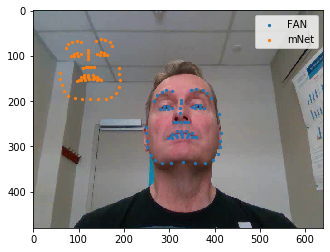

In [57]:
%matplotlib inline
n = 270
plt.imshow(imgs[n].permute(1,2,0)/255)


plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
#plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')
plt.legend()

# Get the 3d metric measures 

In [ ]:
def get3dlandmarks(BAG_File, info_file, csv_file, sufix = 'landmarks'):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = ["",""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_landmarks['Time_Stamp (s)']
    DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames(100)

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][6:]   
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,2:] =coords
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
        
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)


In [ ]:
def get3dlandmarks(BAG_File, info_file, csv_file, sufix = 'landmarks'):

    DF_landmarks = pd.read_csv(csv_file, index_col=0)

    DF_info = pd.read_csv(info_file, index_col=0)


    # create dataframe to store information about 3d position of landmarks
    df_cols_p1 = ["Video_Frame_number", 'Time_Stamp (s)']
    for i in range(0, 68):
        num = str(i)
        xx = 'landmark_' + num
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)
        df_cols_p1.append(xx)

    df_cols_p2 = ["",""]
    for i in range(0, 68):
        df_cols_p2.append("x")
        df_cols_p2.append("y")
        df_cols_p2.append("z")

    header = [np.array(df_cols_p1),
              np.array(df_cols_p2)]

    DF_3dpositions = pd.DataFrame(columns=header)

    DF_3dpositions['Time_Stamp (s)'] = DF_landmarks['Time_Stamp (s)']
    DF_3dpositions['Video_Frame_number'] = DF_landmarks['Video_Frame_number']

    # start the process of extracting the video information for each video
    pipeline = rs.pipeline()
    config = rs.config()

    rs.config.enable_device_from_file(config, BAG_File, repeat_playback=False)

    config.enable_all_streams()
    profile = pipeline.start(config)

    # create alignment object
    align_to = rs.stream.color
    align = rs.align(align_to)

    # Getting the depth sensor's depth scale (see rs-align example for explanation)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()

    # inform the device that this is not live streaming from camera
    playback = profile.get_device().as_playback()
    playback.set_real_time(False)
    duration = playback.get_duration()

    # fill holes in the depth information (based on this example: https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/depth_filters.ipynb)
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.filter_magnitude, 2)
    spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
    spatial.set_option(rs.option.filter_smooth_delta, 20)
    spatial.set_option(rs.option.holes_fill, 3)

    true_frame_number = []
    frame_number = []
    time_st = []

    num_frame = 0

    try:
        while True:
            frames = pipeline.wait_for_frames(100)

            this_frame = frames.get_frame_number()  # get frame number        
            landmarks=None
            # verify that we have landmarks for this particular frame

            try:
                vid_frame = DF_info.Frame_Number_in_Video.loc[DF_info["BAG_Frame_Number"]==this_frame].values[0] 

                index_ = DF_info.index[DF_info['BAG_Frame_Number']==this_frame]

                landmarks = DF_landmarks.iloc[index_].values[0][6:]   
                landmarks = landmarks.astype('float').reshape(-1, 2)
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_frames = align.process(frames)

                # take color and depth from frame, if any to these is not available then skip the frame
                aligned_depth = aligned_frames.get_depth_frame()
                aligned_color = aligned_frames.get_color_frame()

                # validate that both frames are available
                if not aligned_depth or not aligned_color:
                    continue

                #time_stamp = frames.get_timestamp()
                #true_frame_number.append(frames.get_frame_number())
                #time_st.append(time_stamp)
                #frame_number.append(num_frame)

                # Intrinsics & Extrinsics
                depth_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                color_intrin = aligned_depth.profile.as_video_stream_profile().intrinsics
                depth_to_color_extrin = aligned_depth.profile.get_extrinsics_to(aligned_color.profile)

                aligned_filtered_depth = spatial.process(aligned_depth)
                depth_frame_array = np.asanyarray(aligned_filtered_depth.as_frame().get_data())
                depth_frame_array = depth_frame_array * depth_scale

                coords = []

                for (c,
                     r) in landmarks:  # landmarks provide the x,y position of each landmark. x are columns and y are rows in the figure
                    # depth_value = depth_frame.get_distance(int(c),int(r))
                    # x,y,z = rs.rs2_deproject_pixel_to_point(depth_intrin, [int(c), int(r)], depth_value)
                    try:
                        depth_value = depth_frame_array[int(r), int(c)]
                    except IndexError:
                        h,w = depth_frame_array.shape
                        if r>w-1:r=h-1
                        if c>h-1:c=w-1
                        depth_value = depth_frame_array[int(r), int(c)]

                    z = depth_value
                    x = z * ((c - depth_intrin.ppx) / depth_intrin.fx)
                    y = z * ((r - depth_intrin.ppy) / depth_intrin.fy)
                    coords.append(x), coords.append(y), coords.append(z)

                DF_3dpositions.loc[index_,2:] =coords
            except IndexError:
                error= 'Error file:' + BAG_File.split(os.path.sep)[-1] +'\n' + str(this_frame)+' does not exists in color video'
                print(error)


    except RuntimeError:
        pass
    finally:
        pipeline.stop()
        
        
    landmark_file = csv_file[:-4]+'3D.csv'
    DF_3dpositions.to_csv(landmark_file)



In [10]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


error_avi = []

for index, row in avi_df.iterrows():
     
    
    color_file = row['avi_path']
    
    print('Starting: ', color_file)
    print()
    splited_name = color_file.split('/')
    name = splited_name[-1][:-4]
    root_path = '/'.join(splited_name[:-2])
    
    folder  = os.path.join(root_path,output_subfolder)
    csv_name = os.path.join(folder, name + sufix)
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    vid = torchvision.io.read_video(color_file, pts_unit='sec')
    
    
    try: 
        #create batches
        idx = np.arange(vid[0].shape[0])
        batch_size=200
        q = int(idx.shape[0] / batch_size)
        block_end = q * batch_size
        batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

        F,H,W,C = vid[0].shape
        landmarks = np.zeros((F,68,2))
        #this for facial localization 
        des_dim = 128
        yshift, xshift = 0, (H-W)//2
        xstart = (int(W*(128/H))-des_dim)//2

        ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
        resolution = 256
        vid_crop = torch.zeros((F,C,resolution,resolution))

        with torch.no_grad():
            for batch in batch_idx:

                imgs = vid[0][batch,:,:,:]
                imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
                imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
                imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

                bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
                face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 


                centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
                centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
                centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)

                scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale

                #if using FAN, do this
                #imgs_norm = (imgs.div_(255)
                #if using other models do this


                imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
                vid_crop[batch] = imgs_crop
                imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

                outs = model_mobilenet(imgs_crop.to(device))
                landmarks[batch,:,:] = outs[-1].cpu().numpy()

        landmarks = _descale(landmarks,resolution)


        #create a dataframe that will store all the information 
        df_cols = ["fps"]
        #y_col = []
        #x_col = []
        for i in range(0,68):
            num=str(i)
            xx = 'landmark_'+num+'_x'
            yy = 'landmark_'+num+'_y'
            #x_col.append(xx)
            #y_col.append(yy)
            df_cols.append(xx)
            df_cols.append(yy)
        l = landmarks.reshape(landmarks.shape[0],-1)
        LandmarkDataFrame = pd.DataFrame(l,columns = df_cols)
        LandmarkDataFrame["fps"]=vid[2].get('video_fps')
        LandmarkDataFrame.tocsv(csv_name)
        
    except:
        print("ERROR OCCURTED")
        print()
        error_avi.append(color_file)
        pass
        

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_color.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_OPEN_depth.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_color.avi

ERROR OCCURTED

Starting:  /media/deniz/easystore/facial_tracking_data_2021/ALS/AF01_SBK_20170509/02/RSSDK/AF01_02_20170509_NSM_SPREAD_depth.avi



KeyboardInterrupt: 

# Testing with 1 avi File

In [8]:
vid = torchvision.io.read_video(r"/home/deniz/Code/ClinicalScore/test/A013_02_20190110_NSM_BIGSMILE_color.avi", pts_unit='sec')

In [50]:
st=time.time()
#transforms 
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])




#create batches
idx = np.arange(vid[0].shape[0])
batch_size=200
q = int(idx.shape[0] / batch_size)
block_end = q * batch_size
batch_idx = np.split(idx[:block_end], q) + [idx[block_end:]]

F,H,W,C = vid[0].shape
landmarks = np.zeros((F,68,2))
o_landmarks = np.zeros((F,68,2))
#this for facial localization 
des_dim = 128
yshift, xshift = 0, (H-W)//2
xstart = (int(W*(128/H))-des_dim)//2

ref_scale = 195 #adjust this value to have the face smaller or bigger in the image
resolution = 256
vid_crop = torch.zeros((F,C,resolution,resolution))

with torch.no_grad():
    for batch in batch_idx:

        imgs = vid[0][batch,:,:,:]
        imgs = imgs.permute(0,3,1,2)#.type(torch.FloatTensor)
        imgs_bf = nn.functional.interpolate(imgs, (des_dim, int(W*(des_dim/H))))
        imgs_bf = imgs_bf[:,:,:, xstart:xstart+128]

        bboxes = torch.cat(face_detector.predict_on_batch(imgs_bf.to(device)))
        face_locs = torch.cat((bboxes[:,1:2], bboxes[:,0:1], bboxes[:,3:4], bboxes[:,2:3]), dim=1) * H + torch.tensor([int((W-H)/2), 0, int((W-H)/2), 0]) 
        

        centersx = face_locs[:,2] - (face_locs[:,2]-face_locs[:,0])/2
        centersy = (face_locs[:,3] - (face_locs[:,3]-face_locs[:,1])/2) - (face_locs[:,3]-face_locs[:,1])*0.12
        centers = torch.cat((centersx.view(-1,1),centersy.view(-1,1)), dim=1)
        
        scales = ((face_locs[:,2]-face_locs[:,0]) + (face_locs[:,3]-face_locs[:,1]))/ref_scale
        
        #if using FAN, do this
        #imgs_norm = (imgs.div_(255)
        #if using other models do this
        
        
        imgs_crop = crop_and_resize_tensor(imgs, centers, scales, resolution=resolution)
        vid_crop[batch] = imgs_crop
        imgs_crop = (imgs_crop.div(255)-MEAN[None,:,None,None]) / STD[None,:,None,None]

        outs = model_mobilenet(imgs_crop.to(device))
        print(len(outs))
        print(outs[0].shape)
        print(outs[1].shape)
        #original[batch,:,:] = tranform_tensor(outs[-1][batch,:,:],centers,scales, resolution, inverse = True)
        landmarks[batch,:,:] = outs[-1].cpu().numpy()
        #o_landmarks[batch,:,:] = tranform_tensor(landmarks[batch,:,:].T,centers,scales, H, inverse = True)
        #x = landmarks[batch,:,0]
        #y = landmarks[batch,:,1]
        d = landmarks[batch,:,:]
        d = landmarks[1,:,:]
       # for b, i, j in zip(batch, x, y):
       #     o_landmarks[b,i,j] = tranform_tensor(landmarks[b,i,j].T,centers,scales, H, inverse = True)
            
        for b in batch:
            d = landmarks[b,:,:]
            o_landmarks[b,:,:] = tranform_tensor(d[b],centers,scales, H, inverse = True)
       # o_landmarks +=original  

landmarks = _descale(landmarks,resolution)

#original = _descale(original,resolution)

#create a dataframe that will store all the information 

print(f'FPS = {F/(time.time()-st)}')

2
torch.Size([200, 68, 64, 64])
torch.Size([200, 68, 2])


ValueError: could not broadcast input array from shape (200,3,1) into shape (68,2)

In [13]:
landmarks.shape

(468, 68, 2)

In [14]:
landmarks[1,:,:].shape

(68, 2)

In [25]:
a = landmarks[1,:,:].T
a[0].shape

(68,)

In [52]:
scales.shape

torch.Size([200])

In [32]:
x = landmarks[batch,:,0]
y = landmarks[batch,:,1]
for b, i, j in zip(batch, x, y):
    print(b,i,j)

0 [-0.47618791 -0.47312108 -0.45752919 -0.4274694  -0.36568344 -0.28458336
 -0.18422306 -0.05905213  0.06250361  0.19039789  0.30570644  0.37596598
  0.42176616  0.44656894  0.45541847  0.4348956   0.42286009 -0.36167568
 -0.2962923  -0.22277194 -0.15734845 -0.09597282  0.06395307  0.11380407
  0.18345642  0.2514824   0.31723881 -0.00647356  0.00471471  0.02326647
  0.03555135 -0.06278621 -0.02095548  0.03076717  0.07464652  0.10780477
 -0.29255912 -0.23876227 -0.17861591 -0.12761205 -0.17822832 -0.23496354
  0.10625017  0.1465216   0.20067047  0.24669147  0.19654873  0.15025371
 -0.1357829  -0.07932772 -0.0183723   0.04438097  0.09705181  0.15476447
  0.19824749  0.15884146  0.10644237  0.03993902 -0.02459676 -0.07836403
 -0.10318869 -0.02711935  0.03813769  0.10848442  0.17823985  0.11066806
  0.04285809 -0.02727048] [-0.0721626   0.03638265  0.15665698  0.28438184  0.40780377  0.49127477
  0.55480671  0.58685189  0.5885427   0.55808055  0.4888581   0.40721118
  0.32063645  0.2005143

In [59]:
preds_orig[i, j] = np.transform(preds[i, j], center, scale, H, True)

AttributeError: module 'numpy' has no attribute 'transform'

In [24]:
#landmarks = _descale(landmarks,resolution)
%matplotlib qt
plt.plot(np.linalg.norm(landmarks[:,57,:]-landmarks[:,51,:], axis=1),'--o')
    



In [25]:
landmarks.shape

(468, 68, 2)

In [26]:
landmarks[:,:,0].shape

(468, 68)

In [27]:
for x, y in landmarks[:,:,]

SyntaxError: invalid syntax (<ipython-input-27-16c2435fc88f>, line 1)

In [ ]:
def tranform_tensor(point, center,scale, resolution, inverse=False):

    _pt = torch.tensor([point[0],point[1],1]).view(-1,1).type(torch.FloatTensor)

    h = 200 * scale
    t = torch.eye(3).repeat(len(scale),1,1)
    t[:,0,0] = resolution / h
    t[:,1,1] = resolution / h
    t[:,0,2] = resolution *(-centers[:,0]/h + 0.5)
    t[:,1,2] = resolution *(-centers[:,1]/h + 0.5)
    if inverse:
        t = torch.inverse(t)

    return torch.matmul(t,_pt)

In [49]:
center = 1
scale = 2
resolution = 256
d = landmarks[1,:,:]
tranform_tensor(d[0], center,scale, resolution, inverse=True)

TypeError: object of type 'int' has no len()

In [38]:
t.shape

(2, 68)

In [42]:
t[1][0]

-0.06451475620269775

In [43]:
d = landmarks[1,:,:]

In [47]:
len(d[:])

68

In [ ]:
t = landmarks[1,:,:].T

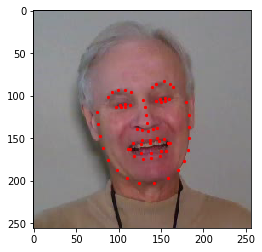

In [28]:
%matplotlib inline
n = 170
plt.imshow(vid_crop[n].permute(1,2,0)/255)
plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')

#plt.imshow(vid[0][n])

In [ ]:
imgs = vid[0][:,:,:,:]
imgs = imgs.permute(0,3,1,2)

In [ ]:
%matplotlib inline

plt.imshow(imgs[n].permute(1,2,0)/255)


#plt.scatter(x_fan.iloc[n][1:],y_fan.iloc[n][1:],s=5, label='FAN')
#plt.scatter(x_mnet.iloc[n][1:-1],y_mnet.iloc[n][1:-1],s=5, label='mNet')
plt.scatter(original[n,:,0], original[n,:,1],s=5, color='red')
plt.legend()

TypeError: Invalid shape (640, 3, 480) for image data

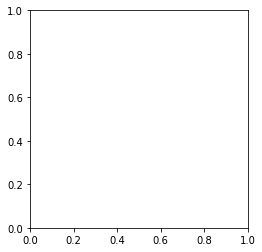

In [30]:
%matplotlib inline
n = 170
plt.imshow(vid[0][n].permute(1,2,0)/255)
plt.scatter(landmarks[n,:,0], landmarks[n,:,1],s=5, color='red')

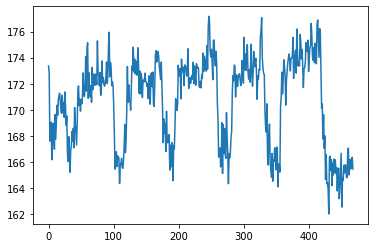

In [29]:
plt.plot(landmarks[:,57,1])

In [ ]:
center = centers
scale = scales

N,C,H,W = imgs.shape
ul_b = tranform_tensor([1,1],center,scale, resolution, inverse = True)
br_b = tranform_tensor([resolution,resolution],center,scale, resolution, inverse = True)
out_imgs = torch.zeros((N,C,resolution,resolution))
for ul_t,bl_t, k in zip(ul_b,br_b, np.arange(N)):
    ul=np.round(ul_t.numpy(),0).astype(np.int)
    br=np.round(bl_t.numpy(),0).astype(np.int)
    newImg = torch.zeros([C,int(br[1]-ul[1]),int(br[0]-ul[0])]).int()
    newX = np.array(
    [max(1, -ul[0] + 1), min(br[0], W) - ul[0]], dtype=np.int32)
    newY = np.array(
    [max(1, -ul[1] + 1), min(br[1], H) - ul[1]], dtype=np.int32)
    oldX = np.array([max(1, ul[0] + 1), min(br[0], W)], dtype=np.int32)
    oldY = np.array([max(1, ul[1] + 1), min(br[1], H)], dtype=np.int32)

    #newImg[:,int(newY[0]) - 1:int(newY[1]), int(newX[0]) - 1:int(newX[1])
    #   ] = image[:,int(oldY[0]) - 1:int(oldY[1]), int(oldX[0]) - 1:int(oldX[1])]

    newImg[:,int(newY[0]):int(newY[1]), int(newX[0]):int(newX[1])] = imgs[k][:,int(oldY[0]):int(oldY[1]), int(oldX[0]):int(oldX[1])]
    out_imgs[k] = nn.functional.interpolate(newImg.unsqueeze(0).float(), size=(resolution, resolution))


In [ ]:
plt.imshow(out_imgs[50].permute(1,2,0)/255)

In [ ]:
F